In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [1]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster

import matplotlib.pyplot as plt
import os
import time
import numpy

In [2]:
#Bring a DeepForest pretrained model into environment
model = main.deepforest()
model.use_release()

Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /home/jovyan/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 96.6MB/s] 
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NEON.pt: 129MB [00:01, 101MB/s]                               


Model was downloaded and saved to /opt/conda/lib/python3.11/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


## Predict Tree Crowns on Raw (non-georeferenced images)

In [3]:
#Path for the image you want to ID trees. These are non-georeferenced single jpeg drone image. In this example, the image data is in Cyverse
image_path = get_data("/data-store/iplant/home/shared/commons_repo/curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG")
image_path2 = get_data("/data-store/iplant/home/jgillan/media/DJI_0184.jpeg")
image_path3 = get_data("/data-store/iplant/home/jgillan/media/100_0407_0064.jpeg")
image_path4 = get_data("/data-store/iplant/home/jgillan/media/DJI_0468.jpeg")
image_path5 = get_data("/data-store/iplant/home/jgillan/media/101_0472_0074.jpeg")

In [4]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
trees = model.predict_image(path=image_path3, return_plot = False)
trees

,xmin,ymin,xmax,ymax,label,score,image_path
0,107.0,323.0,176.0,385.0,Tree,0.619734,100_0407_0064.jpeg
1,143.0,69.0,180.0,105.0,Tree,0.554984,100_0407_0064.jpeg
2,55.0,23.0,109.0,80.0,Tree,0.527672,100_0407_0064.jpeg
3,509.0,233.0,541.0,262.0,Tree,0.503347,100_0407_0064.jpeg
4,557.0,188.0,599.0,228.0,Tree,0.497907,100_0407_0064.jpeg
5,65.0,231.0,122.0,294.0,Tree,0.458085,100_0407_0064.jpeg
6,142.0,142.0,172.0,174.0,Tree,0.440365,100_0407_0064.jpeg
7,114.0,0.0,141.0,8.0,Tree,0.393910,100_0407_0064.jpeg
8,101.0,58.0,135.0,92.0,Tree,0.386400,100_0407_0064.jpeg
9,37.0,218.0,76.0,250.0,Tree,0.372510,100_0407_0064.jpeg


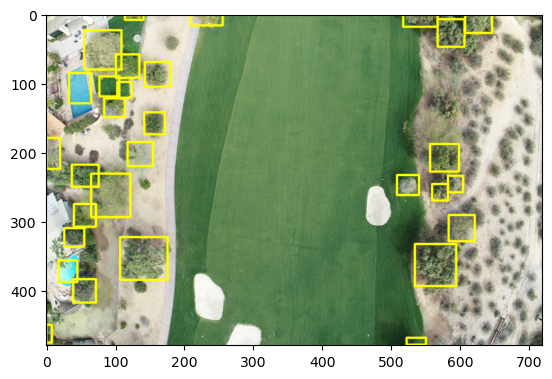

In [5]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path3, return_plot = True, color=(0, 255, 255), thickness=2)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [ ]:
#Set the path for a georeferenced image you want to predict tree crowns
raster_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")

In [ ]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(0, 255, 255), thickness=3)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [5]:
##Convert Georeferenced Training Data (shapefile) to annotation that can be ingested by DeepForest
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training

# training data imagery path
train_image_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")

# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
shp_path = "/data-store/iplant/home/jgillan/media/srer_train.shp"

# Location where you will save the annotation dataframe
savedir = "/data-store/iplant/home/jgillan/media"

In [6]:
##Convert .shp to annoation
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [7]:
#Show the annotation
df

,image_path,xmin,ymin,xmax,ymax,label
0,1a_g2_ortho.tif,7015,5049,7613,5638,Tree
1,1a_g2_ortho.tif,6647,5597,7360,6297,Tree
2,1a_g2_ortho.tif,7338,6157,7734,6436,Tree
3,1a_g2_ortho.tif,7661,5977,8035,6303,Tree
4,1a_g2_ortho.tif,7211,6404,7775,6968,Tree
...,...,...,...,...,...,...
145,1a_g2_ortho.tif,1009,8152,1572,8539,Tree
146,1a_g2_ortho.tif,2503,8007,2776,8349,Tree
147,1a_g2_ortho.tif,2833,7829,3447,8304,Tree
148,1a_g2_ortho.tif,2845,7221,3397,7855,Tree


In [8]:
#Write training data dataframe to csv file
df.to_csv(os.path.join(train_image_dir, "train_example.csv"), index=False)

In [48]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(train_image_dir, "train_example.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(train_image_dir, 'train_data_folder')

# Do the split. It went from having 150 labels to 95. I don't know why!?!?
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=800,
                            patch_overlap=0,
                            allow_empty=False)


In [49]:
#Define path of new annotation table
base_name, _ = os.path.splitext(image_name)
csv_name = base_name + ".csv"
annotation_table = os.path.join(crop_dir, csv_name)

### Split annotation data into training and validation

In [50]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

There are 53 training crown annotations
There are 12 test crown annotations


In [51]:
#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

In [52]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()


#model.config["save-snapshot"] = False

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 2

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [53]:
#model.config["train"]["fast_dev_run"] = True

In [54]:
##TRAIN THE MODEL!
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on CPU: {(time.time() - start_time):.2f} seconds ---")

/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:151: UserWarning: Got processor for bboxes, but no transform to process it.
  warnings.warn(f"Got processor for {proc.default_data_name}, but no transform to process it.")
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


No predictions made


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


--- Training on CPU: 84.68 seconds ---


In [59]:
save_dir = os.path.join(train_image_dir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:151: UserWarning: Got processor for bboxes, but no transform to process it.
  warnings.warn(f"Got processor for {proc.default_data_name}, but no transform to process it.")
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [58]:
results

{'results':    prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
 0              0         0  0.076380  0.229484    60   177    95   206   
 1              1         1  0.000000  0.191874   253   367    32   127   
 0              1         0  0.108560  0.186889   412   551   220   340   
 1              2         1  0.067095  0.167757   595   709   407   508   
 0              0         0  0.358861  0.218491   174   564   210   539   
 0              0         0  0.448465  0.212914    71   800     0   516   
 0              1         0  0.000000  0.201908   606   714   169   248   
 1              0         1  0.181744  0.223114   201   498   137   387   
 0              2         0  0.128039  0.167937   356   505   371   513   
 0              1         0  0.460704  0.198222     0   457    50   456   
 1              2         1  0.252514  0.181590   216   530   487   760   
 0              3         0  0.709844  0.126931   503   800   380   671   
 0            